### exp: eqtl prediction, sign prediction, gpn for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

2024-09-17 14:44:20.913197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 14:44:20.930092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 14:44:20.935040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 14:44:20.948603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 14:44:21.710329: W tensorflow/comp

In [2]:
model_size = ['small','middle','large']
model_list = ['MLP', 'CNN', 'RNN']
tissue = 'Nerve_Tibial'
data_path = '../../../../../datasets_embedding/gpn/eqtl_datasets/sign_prediction/' + tissue + '/'
image_path = 'images_shuffled_seed17/'
# set seed
seed = 17
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0   ENSG00000242485.5   chr1_1407232_G_C_b38           -81  0.182648   
1  ENSG00000157881.13   chr1_2526571_G_C_b38           -57  0.020548   
2   ENSG00000231789.2   chr1_9687685_C_T_b38           130  0.043379   
3   ENSG00000272084.1  chr1_19075748_C_A_b38           237  0.109589   
4   ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.110599   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        147      160  3.926291e-46  0.436504  0.026472      1   
1         17       18  5.059731e-09  0.500525  0.083591      1   
2         36       38  1.409246e-08  0.738330  0.127241      1   
3         91       96  7.632423e-09  0.404185  0.068344      1   
4         93       96  3.275938e-73  0.996535  0.043319      1   

                                          seq_before  \
0  gcactccagcctgggtgacagcgcgagactccgtctcggggtaaga...   
1  cgaaaagggagtaattcgcgttcctcccctagaggtggctgggagg...   
2 

In [4]:
print(train_data['label'].unique())

[0 1]


##### model 1: mlp

accuracy:0.5434782608695652
precision:0.5434782608695652
recall:1.0
f1-score:0.704225352112676


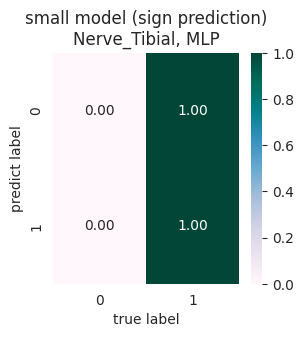

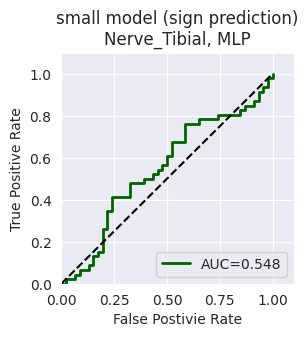

In [5]:
# model 1: mlp
from sklearn.neural_network import MLPClassifier
ml_model = model_list[0]
mlp = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_score = mlp.predict(X_test)                                   
y_score_pro = mlp.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

2024-09-17 14:44:24.941804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22446 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6
2024-09-17 14:44:24.942519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22446 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-09-17 14:44:24.943096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22446 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6
I0000 00:00:1726555466.235110  438962 service.cc:146] XLA service 0x7e72e800b5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726555466.235147  438962 serv

accuracy:0.5869565217391305
precision:0.5714285714285714
recall:0.96
f1-score:0.7164179104477612


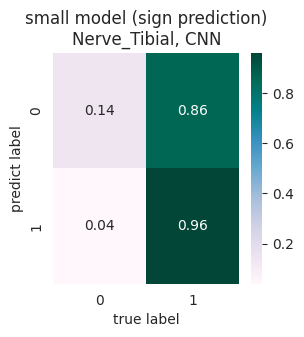

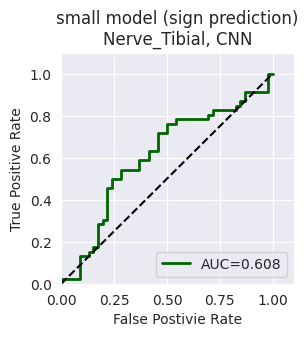

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = cnn.predict(X_test_reshape)                                   
y_score_pro = cnn.predict_proba(X_test_reshape) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

accuracy:0.5652173913043478
precision:0.5714285714285714
recall:0.8
f1-score:0.6666666666666666


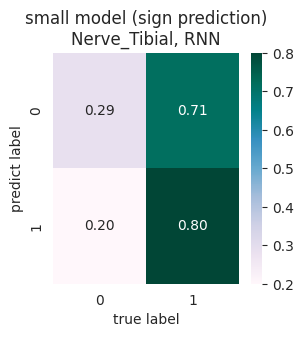

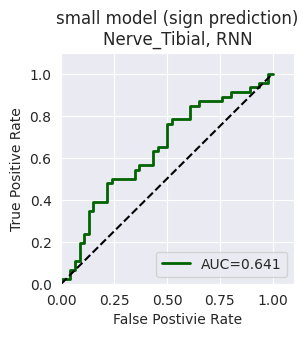

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasClassifier(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = rnn.predict(X_test_reshape)                                   
y_score_pro = rnn.predict_proba(X_test_reshape)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [8]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0   ENSG00000272512.1   chr1_989148_C_A_b38         -8903  0.455742   
1   ENSG00000272512.1   chr1_999842_C_A_b38          1791  0.444064   
2  ENSG00000008128.22  chr1_1733506_G_A_b38          9182  0.013699   
3  ENSG00000008130.15  chr1_1777680_C_T_b38         -2777  0.076484   
4   ENSG00000182873.5  chr1_2189679_C_T_b38          5290  0.378995   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        315      400  6.301756e-45  0.753825  0.046540      1   
1        301      389  2.103221e-49  0.757170  0.043822      1   
2         12       12  2.895097e-10  1.414804  0.218233      1   
3         66       67  3.749908e-13  0.248043  0.032905      1   
4        276      332  4.958885e-20  0.558117  0.057414      1   

                                          seq_before  \
0  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
1  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
2  ttcag

##### model 1: mlp

accuracy:0.5588235294117647
precision:0.5588235294117647
recall:1.0
f1-score:0.7169811320754716


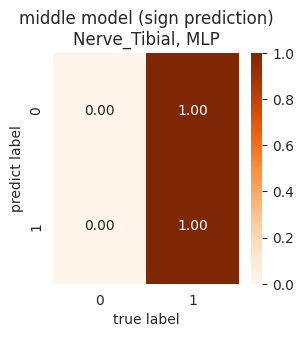

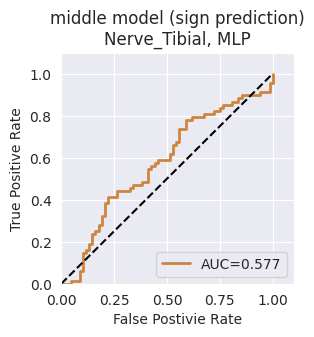

In [9]:
# model 1: mlp
from sklearn.neural_network import MLPClassifier
ml_model = model_list[0]
mlp = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_score = mlp.predict(X_test)                                   
y_score_pro = mlp.predict_proba(X_test)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

accuracy:0.5147058823529411
precision:0.5555555555555556
recall:0.6578947368421053
f1-score:0.6024096385542169


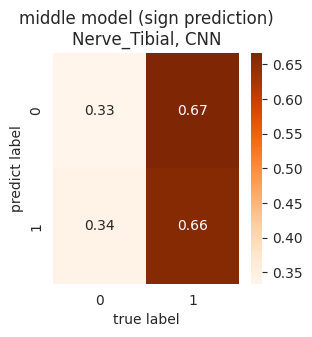

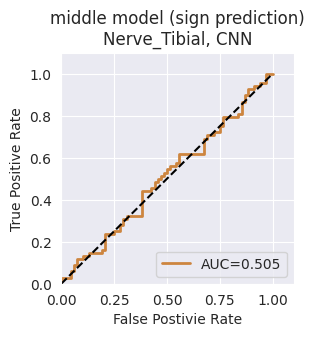

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = cnn.predict(X_test_reshape)                                   
y_score_pro = cnn.predict_proba(X_test_reshape) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

accuracy:0.45588235294117646
precision:0.5102040816326531
recall:0.6578947368421053
f1-score:0.5747126436781609


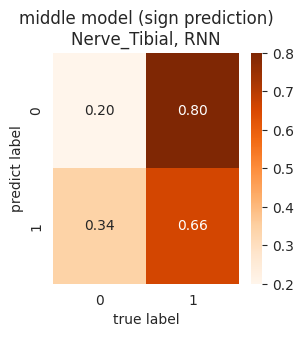

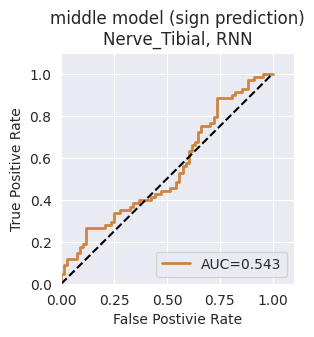

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasClassifier(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = rnn.predict(X_test_reshape)                                   
y_score_pro = rnn.predict_proba(X_test_reshape) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [12]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0   ENSG00000228463.9   chr1_286747_A_G_b38        -10755  0.156393   
1  ENSG00000131591.17  chr1_1091327_C_A_b38        -25034  0.428082   
2   ENSG00000269737.2  chr1_1655861_G_A_b38        -16129  0.033105   
3   ENSG00000227775.3  chr1_1659060_G_A_b38        -65452  0.255760   
4   ENSG00000215790.6  chr1_1733506_G_A_b38        -12486  0.013699   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        126      137  1.063090e-10  0.577437  0.086836      1   
1        299      375  6.088189e-20  0.226558  0.023370      1   
2         29       29  1.404384e-56  1.941307  0.102178      1   
3        194      224  3.861312e-70  0.909623  0.040866      1   
4         12       12  1.044913e-08  1.295409  0.221167      1   

                                          seq_before  \
0  gagaatcacttgaaccagggaggtggaggttgcagtgtgccaagat...   
1  taatttttgtatttttagtagagatggggtttcatcatgttggcca...   
2  tttca

##### model 1: mlp

accuracy:0.48672566371681414
precision:0.54
recall:0.43548387096774194
f1-score:0.48214285714285715


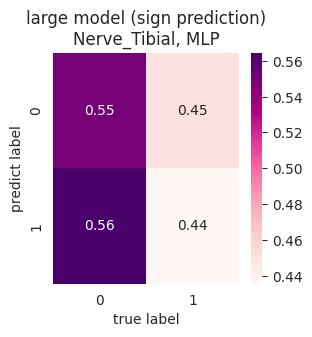

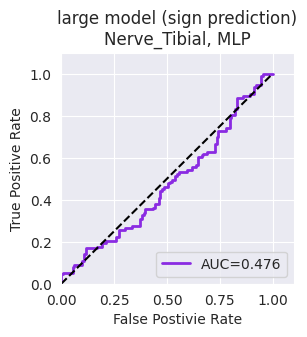

In [13]:
# model 1: mlp
from sklearn.neural_network import MLPClassifier
ml_model = model_list[0]
mlp = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_score = mlp.predict(X_test)                                   
y_score_pro = mlp.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

accuracy:0.4424778761061947
precision:0.4883720930232558
recall:0.3387096774193548
f1-score:0.4


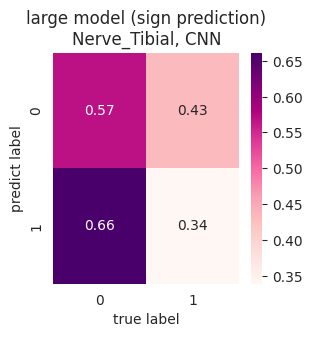

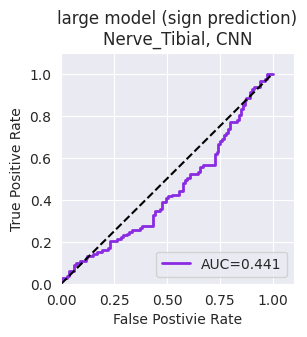

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = cnn.predict(X_test_reshape)                                   
y_score_pro = cnn.predict_proba(X_test_reshape) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

accuracy:0.48672566371681414
precision:1.0
recall:0.06451612903225806
f1-score:0.12121212121212122


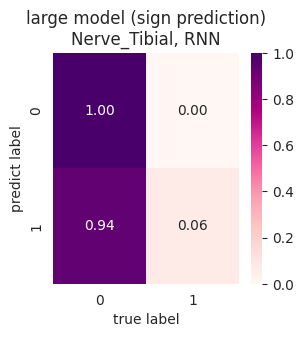

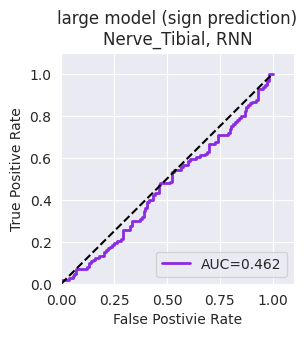

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasClassifier(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = rnn.predict(X_test_reshape)                                   
y_score_pro = rnn.predict_proba(X_test_reshape)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()